In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2)  # reproducible

In [2]:
EMPTY = 0
PLAYER_X = 1
PLAYER_O = 2
DRAW = 3
CHESSBOARD = "-------------------\n" \
    + "| {0} | {1} | {2} |\n" \
    + "------------------\n" \
    + "| {3} | {4} | {5} |\n" \
    + "------------------\n" \
    + "| {6} | {7} | {8} |\n" \
    + "-------------------"
SYMBOLS = [' ', 'X', 'O']
    
get_player_name = lambda player: 'PLAYER_X' if player==1 else 'PLAYER_O'
    
class Environment(object):
    def __init__(self):
        self.state = self.reset_state()

    def reset_state(self):
        return np.array([[EMPTY,EMPTY,EMPTY],[EMPTY,EMPTY,EMPTY],[EMPTY,EMPTY,EMPTY]])
    
    def update_state(self, move, player):
        self.state[move[0]][move[1]] = player
        
    def print_chessboard(self):
        state_one_dim = self.state.reshape(-1)
        #state_one_dim = [np.random.randint(3) for i in xrange(9)]
        print(CHESSBOARD.format(*[SYMBOLS[p] for p in state_one_dim]))
    
    def check_if_gameover(self):
        ''' return the winner '''
        
        state = self.state
        
        # check each row and each col
        for i in range(3):
            if state[i][0] != EMPTY and state[i][0] == state[i][1] and state[i][0] == state[i][2]:
                return state[i][0]
            if state[0][i] != EMPTY and state[0][i] == state[1][i] and state[0][i] == state[2][i]:
                return state[0][i]

        # check diagonals
        if state[0][0] != EMPTY and state[0][0] == state[1][1] and state[0][0] == state[2][2]:
            return state[0][0]
        if state[0][2] != EMPTY and state[0][2] == state[1][1] and state[0][2] == state[2][0]:
            return state[0][2]

        ## each if empty
        for i in range(3):
            for j in range(3):
                if state[i][j] == EMPTY:
                    return EMPTY

        return DRAW
    


In [3]:
class Agent(object):
    def __init__(self, player, learning=True, epsilon=0.1, alpha=0.99, loss_val=-1):
        self.player = player
        self.value_table = {}
        self.epsilon = epsilon # ratio for no greedy
        self.alpha = alpha
        self.winner = EMPTY
        self.prev_state = None
        self.prev_val = 0
        self.learning = learning
        self.loss_val = loss_val
    
    def lookup_value(self, state, no_update=False):
        key = self.stringfy_state(state)
        if no_update != True:
            if key not in self.value_table:
                self.value_table[key] = 0.5
            return self.value_table[key]
        else:
            if key not in self.value_table:
                return '?'
            return self.value_table[key]           
        
    def choose_action(self, state):
        r = np.random.rand()
        if r < self.epsilon:
            move = self.randomly_choose_action(state)
        else:
            move = self.greedily_choose_action(state)
        state[move[0]][move[1]] = self.player
        self.prev_state = self.stringfy_state(state)
        self.prev_val = self.lookup_value(state)
        state[move[0]][move[1]] = EMPTY
        return move
        
    def randomly_choose_action(self, state):
        options = []
        for i in xrange(3):
            for j in xrange(3):
                if state[i][j] == EMPTY:
                    options.append((i, j))
        move = options[np.random.randint(len(options))]
        return move

    def greedily_choose_action(self, state):
        maxval = -10000
        maxmove = None
        for i in range(3):
            for j in range(3):
                if state[i][j] == EMPTY:
                    state[i][j] = self.player
                    val = self.lookup_value(state)
                    state[i][j] = EMPTY
                    if val > maxval:
                        maxval = val
                        maxmove = (i, j)
        self.backup(maxval)
        return maxmove
    
    def backup(self, nextval):
        ''' V(s) <- V(s) + alpha * [ V(s') - V(s) ] '''
        if self.prev_state != None and self.learning:
            self.value_table[self.prev_state] += self.alpha * (nextval - self.prev_val)
    
    def receive_signal(self, winner):
        self.winner = winner
    
    def winner_val(self, winner):
        if self.winner == self.player:
            return 1
        elif self.winner == EMPTY:
            return 0.5
        elif self.winner == DRAW:
            return 0
        else: # loss
            return self.loss_val

    def episode_over(self, winner):
        self.backup(self.winner_val(winner))
        self.prev_state = None
        self.prev_val = 0
        
    def stringfy_state(self, state):
        return ''.join([ str(d) for d in state.reshape(-1)])
    
    def print_value(self, state):
        cells = []
        for i in range(3):
            for j in range(3):
                if state[i][j] == EMPTY:
                    state[i][j] = self.player
                    val = self.lookup_value(state, no_update=True)
                    cells.append(val)
                    state[i][j] = EMPTY
                else:
                    cells.append(SYMBOLS[state[i][j]])
        
        print(CHESSBOARD.format(*cells))

In [4]:
def play(env, agent1, agent2, verbose=False):
    winner = None
    for i in range(9):
        '''a agent takes actions as a response to the state of the environment'''
        player = (i % 2) + 1
        if player == PLAYER_X:
            move = agent1.choose_action(env.state)
            #if verbose:
            #    print('%s\'s turn'% (get_player_name(player)))
            #    agent1.print_value(env.state)
        else:
            move = agent2.choose_action(env.state)
            #if verbose:
            #    print('%s\'s turn'% (get_player_name(player)))
            #    agent2.print_value(env.state)
                
        env.update_state(move, player)
        
        if verbose:
            print('%s\'s choice: %s'% (get_player_name(player), str(move)))
            env.print_chessboard()
        
        '''the environment gives reward to agents'''
        winner = env.check_if_gameover()
        agent1.receive_signal(winner)
        agent2.receive_signal(winner)
        
        '''check if game is over'''
        if winner != EMPTY:
            return winner
    return winner

    

In [5]:
def learn():
    agent1 = Agent(PLAYER_X)
    agent2 = Agent(PLAYER_O)
    
    series = ['agent1-WIN','agent1-LOSE','agent1-DRAW','agent2-WIN','agent2-LOSE','agent2-DRAW']
    colors = ['red','blue','green','magenta','black','cyan']
    perf = [[] for _ in range(len(series) + 1)]
    
    for i in range(10000):
        env = Environment()
        winner = play(env, agent1, agent2)
        agent1.episode_over(winner)
        agent2.episode_over(winner)
        
        if i % 50 == 0:
            probs = measure_performance_vs_random(agent1, agent2)
            perf[0].append(i)
            for idx, x in enumerate(probs):
                perf[idx+1].append(x)     
            if i % 500 == 0:
                print('Iter: %s, probs: %s' % (i, probs))

    for i in range(1, len(perf)):
        #if i in [1, 2, 4, 5]:
        plt.plot(perf[0], perf[i], label=series[i-1], color=colors[i-1])
    plt.xlabel('Episodes')
    plt.ylabel('Probability')
    plt.title('RL Agent vs. Random Agent')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.show()
    
    return agent1, agent2


def measure_performance_vs_random(agent1, agent2):
    random_agent_1 = Agent(PLAYER_X, epsilon=1, learning=False, loss_val=-1)
    random_agent_2 = Agent(PLAYER_O, epsilon=1, learning=False, loss_val=-1)    
    
    probs = np.zeros(6)
    N_GAMES = 100
    for i in range(N_GAMES):
        env = Environment()
        winner = play(env, agent1, random_agent_2)
        agent1.episode_over(winner)
        random_agent_2.episode_over(winner)
        if winner == PLAYER_X:
            probs[0] += 1.0 / N_GAMES
        elif winner == PLAYER_O:
            probs[1] += 1.0 / N_GAMES
        else:
            probs[2] += 1.0 / N_GAMES

    for i in range(N_GAMES):
        env = Environment()
        winner = play(env, random_agent_1, agent2)
        random_agent_1.episode_over(winner)
        agent2.episode_over(winner)
        if winner == PLAYER_O:
            probs[3] += 1.0 / N_GAMES
        elif winner == PLAYER_X:
            probs[4] += 1.0 / N_GAMES
        else:
            probs[5] += 1.0 / N_GAMES
                
    return probs



Let's train it.

Iter: 0, probs: [ 0.77  0.2   0.03  0.47  0.5   0.03]
Iter: 500, probs: [ 0.91  0.08  0.01  0.64  0.3   0.06]
Iter: 1000, probs: [ 0.95  0.01  0.04  0.75  0.17  0.08]
Iter: 1500, probs: [ 0.88  0.08  0.04  0.76  0.15  0.09]
Iter: 2000, probs: [ 0.94  0.04  0.02  0.76  0.15  0.09]
Iter: 2500, probs: [ 0.94  0.03  0.03  0.76  0.14  0.1 ]
Iter: 3000, probs: [ 0.9   0.06  0.04  0.74  0.15  0.11]
Iter: 3500, probs: [ 0.96  0.01  0.03  0.8   0.09  0.11]
Iter: 4000, probs: [ 0.94  0.05  0.01  0.8   0.07  0.13]
Iter: 4500, probs: [ 0.91  0.02  0.07  0.8   0.09  0.11]
Iter: 5000, probs: [ 0.93  0.04  0.03  0.79  0.11  0.1 ]
Iter: 5500, probs: [ 0.96  0.    0.04  0.78  0.09  0.13]
Iter: 6000, probs: [ 0.95  0.03  0.02  0.82  0.07  0.11]
Iter: 6500, probs: [ 0.96  0.02  0.02  0.83  0.05  0.12]
Iter: 7000, probs: [ 0.95  0.02  0.03  0.8   0.05  0.15]
Iter: 7500, probs: [ 0.92  0.03  0.05  0.74  0.1   0.16]
Iter: 8000, probs: [ 0.91  0.04  0.05  0.83  0.    0.17]
Iter: 8500, probs: [ 0.95  0.03  0.

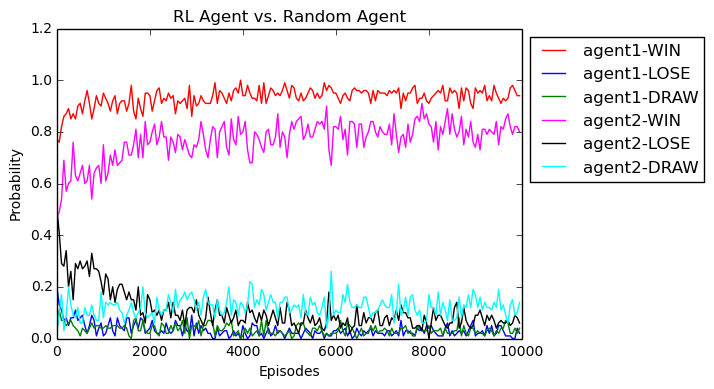

In [6]:
agent1, agent2 = learn()

See the details of a new episode.

In [15]:
env = Environment()
winner = play(env, agent1, agent2, verbose=True)
agent1.episode_over(winner)
agent2.episode_over(winner)

if winner != DRAW:
    print('The winner is %s' % get_player_name(winner))
else:
    print('DRAW')


PLAYER_X's choice: (2, 2)
-------------------
|   |   |   |
------------------
|   |   |   |
------------------
|   |   | X |
-------------------
PLAYER_O's choice: (1, 1)
-------------------
|   |   |   |
------------------
|   | O |   |
------------------
|   |   | X |
-------------------
PLAYER_X's choice: (1, 0)
-------------------
|   |   |   |
------------------
| X | O |   |
------------------
|   |   | X |
-------------------
PLAYER_O's choice: (2, 0)
-------------------
|   |   |   |
------------------
| X | O |   |
------------------
| O |   | X |
-------------------
PLAYER_X's choice: (0, 2)
-------------------
|   |   | X |
------------------
| X | O |   |
------------------
| O |   | X |
-------------------
PLAYER_O's choice: (1, 2)
-------------------
|   |   | X |
------------------
| X | O | O |
------------------
| O |   | X |
-------------------
PLAYER_X's choice: (0, 0)
-------------------
| X |   | X |
------------------
| X | O | O |
------------------
| O |   | X 